# **Import libraries**

In [1]:
!pip install requests PyPDF2
!pip install requests PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 49.6 MB/s eta 0:00:00


In [33]:
from bs4 import BeautifulSoup
import requests
from lxml import etree
import pandas as pd
import csv
from time import sleep
import time
from PyPDF2 import PdfReader
from io import BytesIO
import re
import fitz
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Extract technical sheet**

In [3]:
def extract_text_from_pdf(url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        pdf_stream = io.BytesIO(response.content)
        doc = fitz.open("pdf", pdf_stream)
        text = ""
        for page in doc:
            text += page.get_text()
        doc.close()
        return text
    else:
        print(f"Failed to download the PDF from {url}")
        return ""

# **Extract product detalis**

In [4]:
def scrape_product_details(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        #Extract specific_model
        title = soup.find('h1', class_='product-single__title').get_text(strip=True)

        #Extract reference_number
        sku_element = soup.find('p', class_='product-single__sku')
        sku = sku_element.get_text(strip=True) if sku_element else None

        #Extract price
        price_text = soup.find('span', class_='product__price').get_text(strip=True)

       # Extract currency
        currency = 'USD' if price_text[0] == '$' else price_text[0]

      # Extract price without currency symbol
        price = price_text[1:] if currency == 'USD' else price_text

        # Extract image URL
        image_element = soup.find('img', class_='photoswipe__image')
        image_url = 'https:' + image_element['data-photoswipe-src'] if image_element else 'No image found'

       # Extract marketing_name
        limited_edition_element = soup.find('h3', string=lambda text: text and "LIMITED EDITION" in text.upper())
        if limited_edition_element:
          marketing_name = limited_edition_element.get_text(strip=True)
        else:
          marketing_name = None

        # Extract the watch URL
        product_section = soup.find('div', class_='product-section')
        product_handle = product_section['data-product-handle'] if product_section and 'data-product-handle' in product_section.attrs else None

        # Extract URL
        base_url = 'https://graham1695.com'
        watch_url = f"{base_url}/collections/new-collection/products/{product_handle}" if product_handle else None

         # Extract short description URL
        technical_sheet_link = soup.find('a', string=lambda t: t and "TECHNICAL SHEET AVAILABLE HERE" in t)
        technical_sheet_url = technical_sheet_link['href'] if technical_sheet_link else None



          #Extract parent_model
        collection_name = None
        if "CHRONOFIGHTER VINTAGE" in title:
            collection_name = "CHRONOFIGHTER VINTAGE"
        elif "CHRONOFIGHTER SUPERLIGHT" in title:
            collection_name = "CHRONOFIGHTER SUPERLIGHT"
        elif "SWORDFISH" in title:
            collection_name = "SWORDFISH"
        elif "FORTRESS" in title:
            collection_name = "FORTRESS"


       # Extract description
        description_element = soup.find('div', id='frc-106')
        description = ''
        if description_element:
            paragraphs = description_element.find_all('p')
            description = ' '.join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

        if not description:
            description_heading = soup.find(lambda tag: tag.name == "h3" and "DESCRIPTION" in tag.text)
            if description_heading:
                next_element = description_heading.find_next_sibling('p')
                while next_element:
                    description += next_element.get_text(strip=True) + ' '
                    next_element = next_element.find_next_sibling('p')

          #Pdf sheet
        technical_info = {}
        if technical_sheet_url:
            technical_sheet_text = extract_text_from_pdf(technical_sheet_url)
            regex_patterns = {
     'style': r"Functions:\s*(.+?)\s*(?=\()",
     'diameter': r"Case:[\s\S]*?(\d+\s*mm)",
     'bezel_color': r"Bezel:[^A-Za-z]*([A-Za-z]+)",
     'bezel_material' : r"Bezel:\s*(.*?)(?=,|\.)",
      'water_resistance':  r"Water\s+resistance:\s*([^\n]+)",
     #not work
     'crystal': r"(.*?\bcrystal\b.*)",
      'frequency': r"(\d{2}’\d{3}\s*A/h\s*\(\d+Hz\))",
      'jewels': r"(\d+)\s*jewels",
       'dial_color': r"Dial:\s*([\w\s-]+)",
        'bracelet_material':r"Strap:\s*([\w\s-]+)\s*(?:pin buckle)?",
        'bracelet_color': r"\b(\w+)\s+(?=\b(?:pin\s+)?buckle\b)",
         'clasp_type' :r"(.*?\bpin buckle\b)",
         'movement': r"(Automatic|Manual|Quartz|Solar|Kinetic|Spring\s*Drive|Mechanical|Perpetual\s*Calendar|Tourbillon)",
          'calibre':r"Calibre:\s*([A-Za-z]\d{4})",
           'power_reserve':r"Power reserve:\s*(\d+\s*hours)",
           'case_material':r"\d+\s*mm,\s*([a-zA-Z\s]+)\scase"

            }


            for key, pattern in regex_patterns.items():
                match = re.search(pattern, technical_sheet_text)
                technical_info[key] = match.group(1) if match else None

        product_details = {
            'specific_model': title,
            'nickname':title,
            'reference_number': sku,
            'currency': currency,
            'price': price,
            'image_url': image_url,
            'marketing_name': marketing_name,
            'made_in': 'Switzerland',
            'brand': 'Graham',
            'description': description ,
            'watch_url': watch_url,
            'short_description': technical_sheet_url,
            'parent_model': collection_name,
            **technical_info
            }

        return product_details
    else:
        print(f"Failed to retrieve product details from {url}")
        return {}


# **Save the details in .CSV**

In [5]:
def save_to_csv(details, filename):
    with open(filename, mode='a', newline='') as csvfile:
      fieldnames = [
        'reference_number', 'watch_url', 'type', 'brand', 'year_introduced',
        'parent_model', 'specific_model', 'nickname', 'marketing_name', 'style',
        'currency', 'price', 'image_url', 'made_in', 'case_shape',
        'case_material', 'case_finish', 'caseback', 'diameter', 'between_lugs',
        'lug_to_lug', 'case_thickness', 'bezel_material', 'bezel_color',
        'crystal', 'water_resistance', 'weight', 'dial_color', 'numerals',
        'bracelet_material', 'bracelet_color', 'clasp_type', 'movement',
        'calibre', 'power_reserve', 'frequency', 'jewels', 'features',
        'description', 'short_description']

      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

      if csvfile.tell() == 0:
            writer.writeheader()

      writer.writerow(details)


# **Extract all products**

In [6]:
def scrape_all_products(base_url, pages, filename):
    for page in range(1, pages + 1):
        page_url = f"{base_url}/collections/new-collection?page={page}"
        response = requests.get(page_url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            # Find all product items
            product_items = soup.find_all('div', class_='grid-product__content')

            for item in product_items:

                product_url = base_url + item.find('a', class_='grid-product__link')['href']
                product_details = scrape_product_details(product_url)
                save_to_csv(product_details, filename)

                # Sleep to prevent overwhelming
                time.sleep(1)
        else:
            print(f"Failed to retrieve products from {page_url}")

In [ ]:
base_url = 'https://graham1695.com'
pages = 4
filename = 'graham_products.csv'
scrape_all_products(base_url, pages, filename)

In [ ]:
#Just to test
product_url = 'https://graham1695.com/collections/chronofighter-vintage/products/chronofighter-vintage-limited-edition'
product_details = scrape_product_details(product_url)
save_to_csv(product_details, 'product_details.csv')

# **Summary Report for Graham Website**

In [7]:
df= pd.read_csv("/content/graham_watches.csv")

In [8]:
df.describe()

,year_introduced,case_shape,case_finish,between_lugs,lug_to_lug,case_thickness,weight,numerals,jewels,features
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.000000,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.193548,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.040121,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.000000,NaN


In [10]:
df.head()

,reference_number,watch_url,type,brand,year_introduced,parent_model,specific_model,nickname,marketing_name,style,...,bracelet_color,clasp_type,movement,calibre,power_reserve,frequency,jewels,features,description,short_description
0,2CVAK.G05A.K137T,https://graham1695.com/collections/new-collect...,NaN,Graham,NaN,CHRONOFIGHTER VINTAGE,CHRONOFIGHTER VINTAGE OVERLORD ANNIVERSARY 75 ...,CHRONOFIGHTER VINTAGE OVERLORD ANNIVERSARY 75 ...,LIMITED EDITION,Chronograph,...,Green,Bronze pin buckle,Automatic,G1747,48 hours,28’800 A/h (4Hz),25.0,NaN,"Over the years, Graham has recognised that som...",https://cdn.shopify.com/s/files/1/0274/0921/96...
1,2CVES.B01A,https://graham1695.com/collections/new-collect...,NaN,Graham,NaN,CHRONOFIGHTER VINTAGE,CHRONOFIGHTER VINTAGE 25TH ANNIVERSARY,CHRONOFIGHTER VINTAGE 25TH ANNIVERSARY,LIMITED EDITION,Chronograph,...,brown,Steel pin buckle,Automatic,G1722,48 hours,28’800 A/h (4Hz),30.0,NaN,As part of Graham's 25th anniversary celebrati...,https://cdn.shopify.com/s/files/1/0274/0921/96...
2,2CCCK.O01A,https://graham1695.com/collections/new-collect...,NaN,Graham,NaN,CHRONOFIGHTER SUPERLIGHT,CHRONOFIGHTER SUPERLIGHT CARBON SKELETON - TRA...,CHRONOFIGHTER SUPERLIGHT CARBON SKELETON - TRA...,NaN,Skeleton chronograph,...,black,Black carbon pin buckle,Automatic,G1790,48 hours,28’800 A/h (4Hz),29.0,NaN,The Chronofighter Superlight Carbon Skeleton w...,https://cdn.shopify.com/s/files/1/0274/0921/96...
3,2FOBC.R01A,https://graham1695.com/collections/new-collect...,NaN,Graham,NaN,FORTRESS,FORTRESS CITY GMT RED,FORTRESS CITY GMT RED,NaN,GMT,...,black,Steel pin buckle,Automatic,G1725,42 hours,28’800 A/h (4Hz),26.0,NaN,The Fortress City GMT Red is equipped with a m...,https://cdn.shopify.com/s/files/1/0274/0921/96...
4,2FOAS.G05A,https://graham1695.com/collections/new-collect...,NaN,Graham,NaN,FORTRESS,FORTRESS GREEN,FORTRESS GREEN,LIMITED EDITION,Chronograph,...,black,Steel pin buckle,Automatic,G1750,48 hours,28’800 A/h (4Hz),25.0,NaN,The Graham Fortress is a chronograph equipped ...,https://cdn.shopify.com/s/files/1/0274/0921/96...


In [24]:
#convert data type to float
df['price'] = df['price'].astype(float)

In [25]:
#Calculate average and median prices
median_price = round(df['price'].median(),2)
average_price = round(df['price'].mean(),2)

In [28]:
print("Median price=",median_price)
print("Average price=",average_price)

Median price= 7950.0
Average price= 9727.78


In [57]:
# Display the top 5 highest priced watches
top_5_high_prices = df.sort_values(by='price', ascending=False).head(5)
top_5_high_prices[['nickname', 'price']]

,nickname,price
61,CHRONOFIGHTER SUPERLIGHT CARBON SKELETON TOURB...,44950.0
2,CHRONOFIGHTER SUPERLIGHT CARBON SKELETON - TRA...,15950.0
39,CHRONOFIGHTER SUPERLIGHT CARBON SKELETON - TRA...,15950.0
16,CHRONOFIGHTER SUPERLIGHT CARBON STRIP SKELETON...,15950.0
15,CHRONOFIGHTER SUPERLIGHT CARBON SKELETON - TRA...,15950.0


In [45]:
#Number of Watches by Parent Model
parent_model_counts = df['parent_model'].value_counts()
parent_model_counts

CHRONOFIGHTER VINTAGE       31
CHRONOFIGHTER SUPERLIGHT    14
FORTRESS                    11
SWORDFISH                    4
CHRONOFIGHTER                3
Name: parent_model, dtype: int64

In [47]:
#how many watches are marked as "Limited Edition"
df['is_limited_edition'] = df['marketing_name'].str.contains('LIMITED EDITION', case=False, na=False)
limited_edition_count = df['is_limited_edition'].sum()
limited_edition_count

16

In [44]:
#total number of jewels for each group
df['jewels'] = pd.to_numeric(df['jewels'], errors='coerce')
total_jewels = df.groupby('parent_model')['jewels'].sum()
total_jewels

parent_model
CHRONOFIGHTER                58.0
CHRONOFIGHTER SUPERLIGHT    387.0
CHRONOFIGHTER VINTAGE       760.0
FORTRESS                    283.0
SWORDFISH                   136.0
Name: jewels, dtype: float64

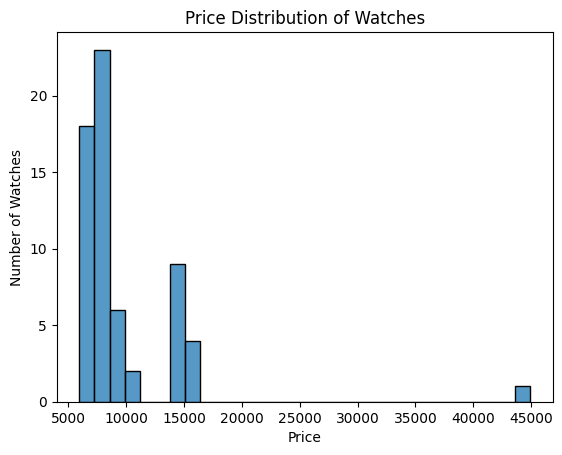

In [21]:
sns.histplot(df['price'], bins=30)
plt.title('Price Distribution of Watches')
plt.xlabel('Price')
plt.ylabel('Number of Watches')
plt.show()

<ipython-input-49-44dd7110ce95>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=parent_model_counts.index, x=parent_model_counts.values, palette='viridis')


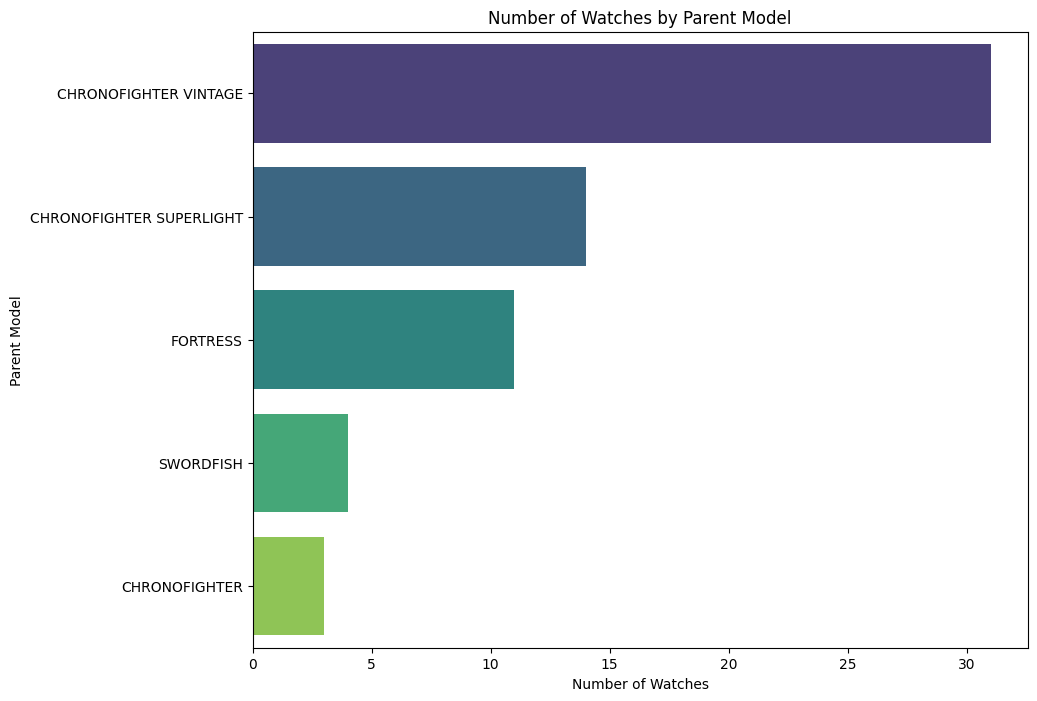

In [49]:
plt.figure(figsize=(10, 8))
sns.barplot(y=parent_model_counts.index, x=parent_model_counts.values, palette='viridis')
plt.title('Number of Watches by Parent Model')
plt.xlabel('Number of Watches')
plt.ylabel('Parent Model')
plt.show()